<h2>This is property price prediction based on locality</h2>

Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import csv


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    sci

<b>Import main data and get a peek of it.</b>

In [2]:
df = pd.read_csv("data/nyc-rolling-sales.csv")
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


<b>Data cleaning</b>
Removing few extreme price/area cases which can break our model 

In [4]:
df1 = df.drop(["Unnamed: 0" , "NEIGHBORHOOD" , "EASE-MENT" , "TAX CLASS AT PRESENT" , "BUILDING CLASS AT PRESENT" , "ADDRESS" , "APARTMENT NUMBER" , "BLOCK" , "LOT"], axis=1)

#df1[df1['SALE PRICE'] == '-']

df1 = df1[df1['SALE PRICE'] != " -  "]
df1['SALE PRICE'] = pd.to_numeric(df1['SALE PRICE'])
df1 = df1[df1['SALE PRICE'] > 900]

df1 = df1[df1['GROSS SQUARE FEET'] != " -  "]
df1['GROSS SQUARE FEET'] = pd.to_numeric(df1['GROSS SQUARE FEET'])
df1 = df1[df1['GROSS SQUARE FEET'] > 10]


df1 = df1[df1['LAND SQUARE FEET'] != " -  "]
df1['LAND SQUARE FEET'] = pd.to_numeric(df1['LAND SQUARE FEET'])
df1 = df1[df1['LAND SQUARE FEET'] > 10]


df1 = df1[df1['ZIP CODE'] > 10]
df1 = df1[df1['YEAR BUILT'] > 1000]

df1["SALE DATE"] = pd.to_datetime(df1["SALE DATE"]).dt.year

df1["AGE"] = df1["SALE DATE"] - df1['YEAR BUILT']


df1 = df1.drop(["SALE DATE", "YEAR BUILT"], axis=1)



#df1["BUILDING CLASS CATEGORY"].unique()

values_to_filter = dict(df1["BUILDING CLASS CATEGORY"].value_counts()[:3])
#[*values_to_filter]
df1 = df1[df1['BUILDING CLASS CATEGORY'].isin([*values_to_filter])]

df1['BUILDING CLASS CATEGORY'] = df1['BUILDING CLASS CATEGORY'].str.slice(0, 2)
df1['BUILDING CLASS CATEGORY'] = pd.to_numeric(df1['BUILDING CLASS CATEGORY'])

#filter our some outlying data possbibily errors
df1 = df1[df1['SALE PRICE'] < 565000000]
df1 = df1[df1['GROSS SQUARE FEET'] < 1021752]


#
#df1.dtypes

#df1["BUILDING CLASS CATEGORY"].value_counts()

#df1.head()



<b>Plot and see if any regression patterns can be observed</b>

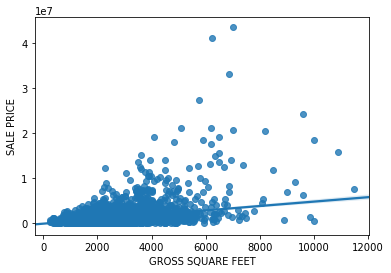

In [5]:
sns.regplot(x="GROSS SQUARE FEET", y="SALE PRICE", data=df1);

In [6]:
from sklearn.cluster import KMeans
#sns.regplot(x="LAND SQUARE FEET", y="SALE PRICE", data=df1);
#Land SQFT doest have a linear relationship on price.
df1.head()


df1["PERSQFT_PRICE"] = df1['SALE PRICE'] / df1["GROSS SQUARE FEET"]

bins=[0,1,2,3]
df1["PRICE BIN"] = pd.cut(df1["PERSQFT_PRICE"], 4 , labels = bins)


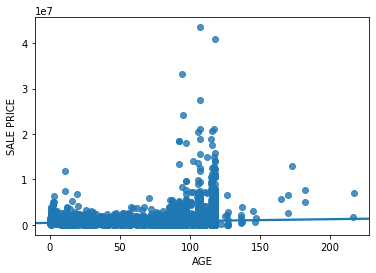

In [7]:
#df1["BUILDING CLASS CATEGORY"].value_counts()
sns.regplot(x="AGE", y="SALE PRICE", data=df1);

<b>Obtain location information using  Nominatim and save it with the data</b>

In [9]:


values_to_filter = dict(df1["ZIP CODE"].value_counts()[:40])
#[*values_to_filter]
df1 = df1[df1['ZIP CODE'].isin([*values_to_filter])]

#print(df1['ZIP CODE'].value_counts())
#GET LOCALITY INFO

#get lat long info from zip


zips = list(dict(df1['ZIP CODE'].value_counts()).keys())

latitude = np.zeros(len(zips))
longitude = np.zeros(len(zips))


i = 0
while i < len(zips):
    geolocator = Nominatim(user_agent="specify_your_app_name_here1")
    
    if 11419== zips[i] :
        latitude[i] = "40.69"
        longitude[i] = "-73.8213"
    elif 10310== zips[i] :
        latitude[i] = "40.6307"
        longitude[i] = "-74.1181"
    elif 11358 == zips[i] :
        latitude[i] = "40.7607"
        longitude[i] = "-73.7978"
    elif 11434 == zips[i] :
        latitude[i] = "40.7027"
        longitude[i] = "-73.7890"
    elif 11234== zips[i] :
        latitude[i] = "40.6008"
        longitude[i] = "-73.9066"
    else:
        location = geolocator.geocode(zips[i])
        latitude[i] = location[1][0]
        longitude[i] = location[1][1]
    i += 1

#zip_df = pd.DataFrame(list(zip(zips, latitude, longitude)), columns =['ZIP', 'LAT' , 'LONG'])

#zip_df.head()

lat_dict = dict(zip(zips, latitude))
long_dict = dict(zip(zips, longitude))


zips_df = np.array(df1['ZIP CODE']) 
latitude_df = np.zeros(len(zips_df))
longitude_df = np.zeros(len(zips_df))



i = 0
while i < len(zips_df):
    #rint(lat_dict.get(zips_df[i]))
    latitude_df[i] = lat_dict.get(zips_df[i])
    longitude_df[i] =long_dict.get(zips_df[i])
    i += 1

    
df1['LATITUDE'] = latitude_df
df1['LONGITUDE'] = longitude_df

df1.head()
#SAVE LATITUDE DATA
#SAVE LONGITUDE DATA



,BOROUGH,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,AGE,PERSQFT_PRICE,PRICE BIN,LATITUDE,LONGITUDE
18374,2,1,10469,1,0,1,1785,1018,1,A5,325000,72,319.253438,0,40.859045,-73.830202
18375,2,1,10469,1,0,1,1786,1018,1,A5,127000,72,124.754420,0,40.859045,-73.830202
18376,2,1,10469,1,0,1,2759,1998,1,A5,400000,71,200.200200,0,40.859045,-73.830202
18379,2,1,10469,1,0,1,1918,1024,1,A2,215982,72,210.919922,0,40.859045,-73.830202
18380,2,1,10469,1,1,2,2465,2112,1,S1,599000,67,283.617424,0,40.859045,-73.830202


<b>Save the zip  vs latitude, zip vs longitude data for ForesuareData.ipynb</b><br>
Rest of the code has to be executed there and dump the related data into Csv/JSON 

In [ ]:

w = csv.writer(open("data/zip_latitude.csv", "w"))
for key, val in lat_dict.items():
    w.writerow([key, val])


w1 = csv.writer(open("data/zip_longitude.csv", "w"))
for key, val in long_dict.items():
    w1.writerow([key, val])




In [12]:
df2 = pd.get_dummies(df1, prefix=['TYPE' , "TAX" , "PRICE"], columns=['BUILDING CLASS CATEGORY', "TAX CLASS AT TIME OF SALE" , "PRICE BIN"])
#df3 = df1.drop(["BUILDING CLASS CATEGORY"], axis=1)

df2.head()


,BOROUGH,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,BUILDING CLASS AT TIME OF SALE,SALE PRICE,AGE,...,LATITUDE,LONGITUDE,TYPE_1,TYPE_2,TYPE_3,TAX_1,PRICE_0,PRICE_1,PRICE_2,PRICE_3
18374,2,10469,1,0,1,1785,1018,A5,325000,72,...,40.859045,-73.830202,1,0,0,1,1,0,0,0
18375,2,10469,1,0,1,1786,1018,A5,127000,72,...,40.859045,-73.830202,1,0,0,1,1,0,0,0
18376,2,10469,1,0,1,2759,1998,A5,400000,71,...,40.859045,-73.830202,1,0,0,1,1,0,0,0
18379,2,10469,1,0,1,1918,1024,A2,215982,72,...,40.859045,-73.830202,1,0,0,1,1,0,0,0
18380,2,10469,1,1,2,2465,2112,S1,599000,67,...,40.859045,-73.830202,1,0,0,1,1,0,0,0


<b>Normalize the data</b>

In [14]:
columns = ["RESIDENTIAL UNITS" , "COMMERCIAL UNITS" , "GROSS SQUARE FEET" , "AGE" ,'TYPE_1',
       'TYPE_2', 'TYPE_3', 'TYPE_7', 'TYPE_8', 'TYPE_14', 'TYPE_21', 'TYPE_22',
       'TYPE_29', 'TYPE_30', 'TAX_1', 'TAX_2', 'TAX_4']

columns =["RESIDENTIAL UNITS" , "COMMERCIAL UNITS" , "GROSS SQUARE FEET" , "AGE" ,'TYPE_1',
       'TYPE_2', 'TYPE_3', 'PRICE_0',	'PRICE_1'	,'PRICE_2',	'PRICE_3']



#columns = ["GROSS SQUARE FEET"]

df2[columns]
scaler = StandardScaler()

X = scaler.fit_transform(df2[columns])
#X = scaler.fit(df2[columns]).transform()

y =scaler.fit_transform(df2[["SALE PRICE"]]) 


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [15]:
#polynomial regression is not used
poly = PolynomialFeatures(degree = 2) 
X_poly = poly.fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

  

In [16]:
lin = LinearRegression() 
  
lin.fit(X_train, y_train) 


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_hat = lin.predict(X_test) 
#print(2)
#mean_squared_error(y_hat, y_test)
#print(accuracy_score(y_hat, y_test))


print(r2_score(y_hat, y_test))


mean_squared_error(y_hat, y_test)




-2.0810034704157525


0.7375330157207082

<b>Deep learning</b>

In [19]:
from sklearn.neural_network import MLPRegressor

alpha = 0.001

regressor = MLPRegressor(hidden_layer_sizes = (10, 10,10, 5), activation = 'relu', solver = 'adam', learning_rate = 'adaptive', alpha = alpha  )
regressor.fit(X_train, y_train)
print(regressor.loss_)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.33946328931295955


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [20]:
y_hat = regressor.predict(X_test)

print(r2_score(y_hat, y_test))


mean_squared_error(y_hat, y_test)




-1.3626290010410909


0.7221341535242789

<b>The following code takes the data from Foresquare data notebook. 

It adds locality information 
</b>

In [21]:
import json

with open('data/zip_nearby_stores.json') as f:
    zip_count_dict1 = json.load(f)

#zip_count_dict1

In [36]:
zips_df = np.array(df1['ZIP CODE']) 


id_list = ['4d4b7104d754a06370d81259' , '4d4b7105d754a06372d81259' , '4d4b7105d754a06374d81259' , '4d4b7105d754a06375d81259' , '4bf58dd8d48988d124941735', '4e67e38e036454776db1fb3a' , '4d4b7105d754a06378d81259' , '4bf58dd8d48988d1fd941735' , '4d4b7105d754a06379d81259' ,'4bf58dd8d48988d1ed931735' , '4bf58dd8d48988d1fe931735' , '4bf58dd8d48988d129951735' ]

id_dict = {k: [] for k in id_list}


i = 0
while i < len(zips_df):
    row_val = zip_count_dict1[str(zips_df[i])]
    for item in row_val:
        id_dict[item].append(row_val[item])
    
    
    i += 1
    
    
print('wow')




wow


In [37]:
count = 0
for item in id_dict:
    df2["Near-" +str(count)] = id_dict[item]
    count= count+1



df2.head()



,BOROUGH,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,BUILDING CLASS AT TIME OF SALE,SALE PRICE,AGE,...,Near-2,Near-3,Near-4,Near-5,Near-6,Near-7,Near-8,Near-9,Near-10,Near-11
18374,2,10469,1,0,1,1785,1018,A5,325000,72,...,22,20,2,4,46,1,11,0,5,0
18375,2,10469,1,0,1,1786,1018,A5,127000,72,...,22,20,2,4,46,1,11,0,5,0
18376,2,10469,1,0,1,2759,1998,A5,400000,71,...,22,20,2,4,46,1,11,0,5,0
18379,2,10469,1,0,1,1918,1024,A2,215982,72,...,22,20,2,4,46,1,11,0,5,0
18380,2,10469,1,1,2,2465,2112,S1,599000,67,...,22,20,2,4,46,1,11,0,5,0


In [35]:
df1.columns

Index(['BOROUGH', 'BUILDING CLASS CATEGORY', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'TAX CLASS AT TIME OF SALE',
       'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'AGE', 'PERSQFT_PRICE',
       'PRICE BIN', 'LATITUDE', 'LONGITUDE', '4d4b7104d754a06370d81259',
       '4d4b7105d754a06372d81259', '4d4b7105d754a06374d81259',
       '4d4b7105d754a06375d81259', '4bf58dd8d48988d124941735',
       '4e67e38e036454776db1fb3a', '4d4b7105d754a06378d81259',
       '4bf58dd8d48988d1fd941735', '4d4b7105d754a06379d81259',
       '4bf58dd8d48988d1ed931735', '4bf58dd8d48988d1fe931735',
       '4bf58dd8d48988d129951735', 'Near-0', 'Near-1', 'Near-2', 'Near-3',
       'Near-4', 'Near-5', 'Near-6', 'Near-7', 'Near-8', 'Near-9', 'Near-10',
       'Near-11'],
      dtype='object')

In [38]:

columns =["RESIDENTIAL UNITS" , "COMMERCIAL UNITS" , "GROSS SQUARE FEET" , "AGE" ,'TYPE_1',
       'TYPE_2', 'TYPE_3', 'PRICE_0',	'PRICE_1'	,'PRICE_2',	'PRICE_3' , 'Near-0', 'Near-1', 'Near-2', 'Near-3',
       'Near-4', 'Near-5', 'Near-6', 'Near-7', 'Near-8', 'Near-9', 'Near-10',
       'Near-11']

#columns = ["GROSS SQUARE FEET"]

df2[columns]
scaler = StandardScaler()

X = scaler.fit_transform(df2[columns])
#X = scaler.fit(df2[columns]).transform()

y =scaler.fit_transform(df2[["SALE PRICE"]]) 



/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [39]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

In [40]:
lin = LinearRegression() 
  
lin.fit(X_train, y_train) 

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_hat = lin.predict(X_test) 
#print(2)
#mean_squared_error(y_hat, y_test)
#print(accuracy_score(y_hat, y_test))


print(r2_score(y_hat, y_test))


mean_squared_error(y_hat, y_test)




-1.0543490745498305


0.6426572458186673

In [41]:
from sklearn.neural_network import MLPRegressor

alpha = 0.001

regressor = MLPRegressor(hidden_layer_sizes = (10, 10,10, 5), activation = 'relu', solver = 'adam', learning_rate = 'adaptive', alpha = alpha  )
regressor.fit(X_train, y_train)
print(regressor.loss_)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.21972131867223735


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [42]:
y_hat = regressor.predict(X_test)

print(r2_score(y_hat, y_test))


mean_squared_error(y_hat, y_test)




-0.033520527721498716


0.4677229474328001

We could see a solid improvement of <b>35%</b> after using the neighbourhood 



<i>0.7221341535242789 to 0.4677229474328001 </i>